In [43]:
import multiprocessing

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pymorphy2
from matplotlib.colors import ListedColormap
from numpy.random import choice
from matplotlib import pyplot as plt

import re

from gensim.models import FastText,KeyedVectors,fasttext

from sklearn import metrics

from scipy import spatial

import torch

from transformers import AutoTokenizer, AutoModel

'''import tensorflow as tf
from tensorflow.keras.layers import Reshape,BatchNormalization,MaxPooling2D,Lambda
from tensorflow.keras.layers import Dense,Activation,Reshape,Conv2D,LeakyReLU,concatenate,Flatten
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop, Adam
'''
from sklearn.model_selection import train_test_split
from sklearn import cluster

import seaborn as sns
import umap

## FAQ

### Get data

In [ ]:
def get_faq(urls,question_data,answer_data):
    #
    #  urls - list [urls1,urls2,..]
    #  question_data, answer_data - list [tag_value,class_value]  
    #
    #  return faq - list shape (n,2), where [:,0] - question, [:,1] - answer
    #
    question_tag,question_class=question_data
    answer_tag,answer_class=answer_data
    
    rs =[ requests.get(url) for url in urls]
    responses = [r.text.encode('utf-8') for r in rs]
    soups = [BeautifulSoup(response) for response in responses]

    faq=[]
    for soup in soups:
        question=soup.findAll(question_tag, class_=question_class)
        answer=soup.findAll(answer_tag,class_=answer_class)
        temp_questions=[]
        temp_answers=[]
        for q in question:
            txt=str(q.text)
            txt=txt.replace('  ','')
            txt=txt.replace('"','')
            txt=txt.replace('	','')
            txt=txt.replace('\n','')
            temp_questions.append(txt)
        for ans in answer:
            txt=str(ans.text)
            txt=txt.replace('  ','')
            txt=txt.replace('	','')
            txt=txt.replace('\n','')
            temp_answers.append(txt)
        
        temp_questions=np.array(temp_questions).reshape((-1,1))
        temp_answers=np.array(temp_answers).reshape((-1,1))
        temp_faq=np.concatenate([temp_questions,temp_answers],axis=1)
        faq.append(temp_faq)
            

    return faq

In [ ]:
urls1=['https://www.mosenergosbyt.ru/common/lobby/questions/category_5749.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_5739.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_48100.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_48101.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_48102.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_48103.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_5745.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_5763.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_5754.php',
     'https://www.mosenergosbyt.ru/common/lobby/questions/category_5716.php']

urls2=['https://mosoblgaz.ru/company/query_answer/']

faq1=get_faq(urls1,['button','btn btn-link collapsed'],['div','collapse'])
faq2=get_faq(urls2,['div','faq-list-item__title js-accordion-item-title'],
             ['div','faq-list-item__text-inner js-accordion-item-inner'])


In [ ]:
df=[]
for document in faq1:
    for line in document:
        df.append(line)
    

df=pd.DataFrame(df,columns = ['Question','Answer'])
df.to_csv('faq.csv',index=False,encoding='utf-8')

In [2]:
faq=pd.read_csv('faq.csv')
faq.head(5)

,Question,Answer
0,Как изменить ФИО собственника?,Для переоформления лицевого счета на нового вл...
1,Как исправить ошибку (или опечатку) в ФИОсобст...,Подать заявку на изменение данных можно в личн...
2,Как изменить телефон?,Изменить номер мобильного телефона можно самос...
3,Как изменить количество проживающих?,Изменить данные о количестве проживающих можно...
4,Как изменить количество комнат?,Изменить данные о количестве комнат можно толь...


### Question answering

In [169]:
class SearchEngine():
    def __init__(self,faq,sbert_name=False,fasttext_path=False):
        self.faq=faq
        if sbert_name:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.sbert_model = AutoModel.from_pretrained(sbert_name)
            self.sbert_model.to(self.device)
            self.sbert_tokenizer = AutoTokenizer.from_pretrained(sbert_name)
            self.sbert_faq_embs=np.array([self.vectorize_sentence_sbert(sent) for sent in self.faq[:,0]])
            
        if fasttext_path:
            self.ft_model= fasttext.FastTextKeyedVectors.load(fasttext_path)
            self.ft_faq_embs=np.array([self.vectorize_sentence_ft(sent) for sent in self.faq[:,0]])
        
    def vectorize_sentence_ft(self,sentence):
        txt=sentence.split()
        val=0
        for word in txt:
            val+=self.ft_model[word]

        return val/len(txt)
    

    def vectorize_sentence_sbert(self,sentence):
    
        encoded_input = self.sbert_tokenizer(sentence,
                                             padding=True,
                                             truncation=True,
                                             max_length=24,
                                             return_tensors='pt').to(self.device)

   #     with torch.no_grad():
        model_output = self.sbert_model(**encoded_input)
            
        #Perform pooling. In this case, mean pooling
        sentence_embedding = self.mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embedding = np.squeeze(sentence_embedding)
        
        return sentence_embedding.cpu().data.numpy()
    

    
    @classmethod
    def mean_pooling(cls,model_output, attention_mask):
        #Mean Pooling - Take attention mask into account for correct averaging
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    def search_faq(self,question,eps,minimal_score,mode,beta):
        if mode=='fasttext':
            vectorizer=self.vectorize_sentence_ft
            faq_embs=self.ft_faq_embs
        elif mode=='sbert':
            vectorizer=self.vectorize_sentence_sbert
            faq_embs=self.sbert_faq_embs

        question_emb=vectorizer(question)
        score=np.zeros((self.faq.shape[0],1))

       
        for i,faq_emb in enumerate(faq_embs):

            distance=1-spatial.distance.cosine( faq_emb,question_emb)
            score[i,0]=distance
                 
        
        faq_logits=np.concatenate([faq,faq_embs,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 3].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,3]
        display_num=0

        for scr in faq_logits[:,2]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         


        
        return faq_logits[:display_num]
    


In [170]:
%%time
sbert_name="sberbank-ai/sbert_large_mt_nlu_ru"
# https://rusvectores.org/ru/models/
fasttext_path='214/model.model'
engine=SearchEngine(faq.values,sbert_name,fasttext_path)


Wall time: 17 s


In [184]:
%%time
noise=' пук кряк пиво интерал'
noise2=' а то я не умею'
question=faq['Question'][51] +noise2
#question='Как оформить льготу '
question='льгота  от расхода'
print('Question: ',question)
print('---------------------')

eps=0.15
minimal_score=0.7
beta=1.5

modes=['fasttext','sbert','both']
mode=modes[0]
vectorizer=engine.vectorize_sentence_ft

output=search_faq(engine,question,eps,minimal_score,mode=mode,beta=beta)

min_val=0.5
#cleaned_question=clean_question(SearchEngine.vectorize_sentence_ft,question,output[:,0],min_val)
print(output)
print('---------------------')
#print('Cleaned question:',cleaned_question)
print('---------------------')


Question:  льгота  от расхода
---------------------
(array([[16.    ,  0.8817],
       [14.    ,  0.878 ],
       [18.    ,  0.8227],
       [17.    ,  0.8192],
       [23.    ,  0.8181],
       [24.    ,  0.8077],
       [20.    ,  0.7886],
       [21.    ,  0.7862],
       [19.    ,  0.7843],
       [25.    ,  0.7695],
       [22.    ,  0.7685],
       [15.    ,  0.7588]]), array([[['Льгота 100 % от расхода',
         'Граждане, которым предусмотрена скидка в размере 100% от расхода по оплате электроэнергии, освобождаются от оплаты за потребленную электроэнергию. Льгота может распространяться как на одного льготника (от оплаты за электроэнергию освобождается только та часть расхода, которая приходится на льготника), так и на льготника с учетом членов его семьи. С перечнем льготных категорий граждан, которым полагается данная льгота можно ознакомиться в Постановлении\xa0Правительства Москвы от 07.12.2004г. № 850-ПП «О порядке и условиях обеспечения мер социальной поддержки граждан по 

In [172]:
 def search_faq(engine,question,eps,minimal_score,mode,beta):
        if mode=='fasttext':
            vectorizer=engine.vectorize_sentence_ft
            faq_embs=engine.ft_faq_embs
        elif mode=='sbert':
            vectorizer=engine.vectorize_sentence_sbert
            faq_embs=engine.sbert_faq_embs

        question_emb=vectorizer(question)
        score=np.zeros((engine.faq.shape[0],1))

       
        for i,faq_emb in enumerate(faq_embs):
            
            distance=1-spatial.distance.cosine( faq_emb,question_emb)
            score[i,0]=round(distance,4)
                 
        index=np.arange(len(engine.faq)).reshape((-1,1))
        
        questions=engine.faq[:,0].reshape((-1,1))
        
        faq_logits=np.concatenate([index,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 1].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,1]
        display_num=0

        for scr in faq_logits[:,1]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         
        faq_logits=faq_logits[:display_num]
        
        questions_indeces=faq_logits[:,0].astype('int64').reshape((1,-1))
        questions=engine.faq[questions_indeces]

        
        return faq_logits,questions
    

In [ ]:
def cluster_questions(faq_logits):
    pass

In [174]:
umap_news=umap.UMAP()
question_emb=vectorizer(question).reshape(1,-1)
data=np.concatenate([engine.ft_faq_embs[output[0][:,0].astype('int32')],question_emb],axis=0)
umaped_vct=umap_news.fit_transform(data)



количество кластеров  2


ValueError: 'c' argument has 12 elements, which is inconsistent with 'x' and 'y' with size 17.

<Figure size 1080x1080 with 0 Axes>

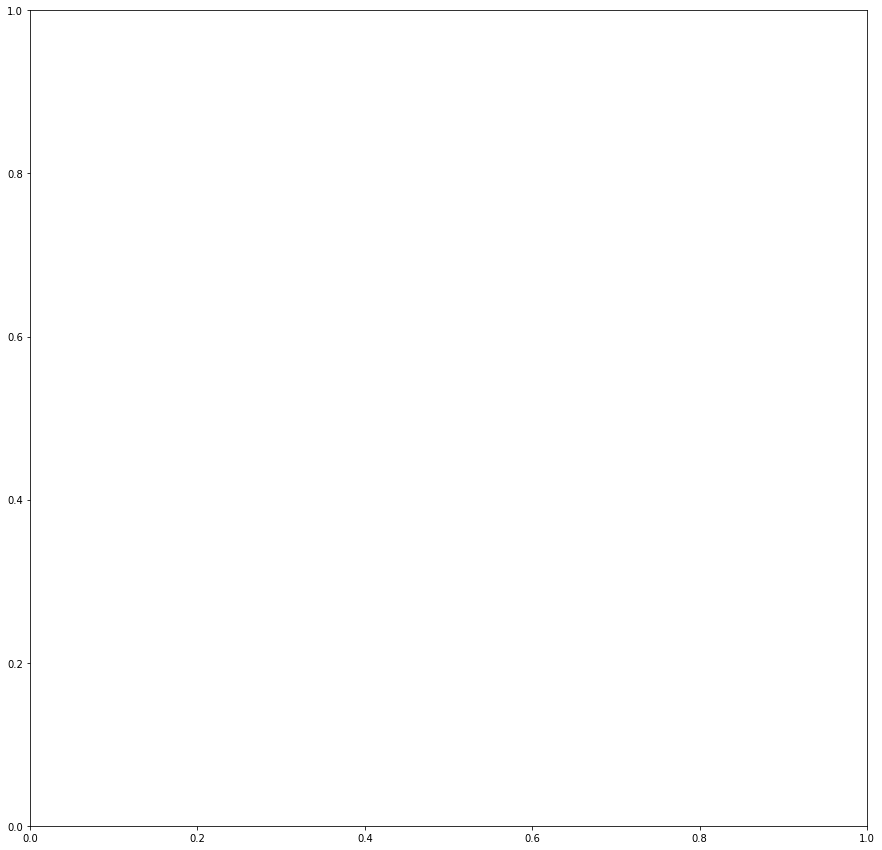

In [186]:
N=15

plt.figure(figsize=(N,N))
#km_clustering = cluster.OPTICS(min_samples=3, xi=.05, min_cluster_size=.05)
km_clustering = KMeans(n_clusters=2)
db_clusters = km_clustering.fit_predict(engine.sbert_faq_embs[output[0][:,0].astype('int32')])

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print('количество кластеров ',max(db_clusters)+1)
N=15
fig, ax = plt.subplots(figsize=(N,N))
#ax.set_title(signs_r[elem],fontsize=20)
ax.scatter(umaped_vct[:-1, 0], umaped_vct[:-1, 1], s=300, c=db_clusters, cmap=myclr)
ax.scatter(umaped_vct[-1, 0], umaped_vct[-1, 1], s=300, c=1, cmap='PRGn_r')
for i,xy in enumerate(umaped_vct[:-1]):
    ax.text(xy[0], xy[1], output[1][0][i][0], fontsize=15,  color='red')
    
ax.text(umaped_vct[-1,0], umaped_vct[-1,1], question, fontsize=15,  color='brown')
plt.show()

In [118]:
 output[1][0][i]

array(['Как оформить льготу в Московской области?',
       'В соответствии с\xa0законом Московской области от 23 марта 2006 г. №\xa036/2006-ОЗ «О социальной поддержке отдельных категорий граждан в Московской области», принятым постановлением Московской областной Думы от 15 марта 2006 г. № 5/171-П, регистрация льгот в Московской области не производится, оплата за потребленную электроэнергию производится в полном объеме согласно действующим тарифам. По вопросу возмещения льгот необходимо обращаться в отделение социальной защиты Вашего муниципального района.'],
      dtype=object)

In [90]:
db_clusters

array([-1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [ ]:
def clean_question(vectorizer,question,pred_questions,min_score):
    question_words=question.split()
    question_words_embs=[vectorizer(word) for word in question_words]
    
    pred_question_words=[]
    for pred_question in pred_questions:
        words=pred_question.split()
        pred_question_words=pred_question_words+words
    
    pred_question_words_embs=[vectorizer(word) for word in pred_question_words]
    
    dlt_inx=[]
    
    for i,question_word_emb in enumerate(question_words_embs):
        word_score=0
        for j,pred_question_word_emb in enumerate(pred_question_words_embs):
            score=1-spatial.distance.cosine(question_word_emb, pred_question_word_emb)
            if score > word_score:
                word_score=score
                
        if word_score<min_score:
            dlt_inx.append(i)
            
    for i in reversed(dlt_inx):
        question_words.pop(i)
    
    return " ".join(question_words)

In [ ]:
questions=['Сборка простой люстры',
'Сборка сложной люстры',
'Установка простой люстры',
'Установка сложной люстры',
'Установка светильника типа Армстронг',
'Установка светильника настенного, бра',
'Установка точечного светильника',
'Подключение светильника Выход',
'Подключени трансформатора для галогенных ламп',
'Установка антивандального светильника']


In [ ]:
q1=questions[:2]
q1

In [ ]:
q2=questions[4:7]
q2_words=[]
morph = pymorphy2.MorphAnalyzer()

for q in q2:
    words=q.split()
    for word in words:
        p = morph.parse(word)[0] 
        q2_words.append(p.normal_form)
        
q2_words=set(q2_words)
q2

In [ ]:
q2_words

In [ ]:


word = "светильником"
p = morph.parse(word)[0]  # Делаем полный разбор, и берем первый вариант разбора (условно "самый вероятный", но не факт что правильный)
print(p.normal_form)  # стать

## Search engine

FastText documents embeddings vs questions

document=questions+answers on one theme

In [ ]:
questions=[]
documents=[]
class_num=len(faq1)
questions2class=dict()
questions_classes=[]



for i,document in enumerate(faq1):
    
    temp_questions=[]
    for line in document:
        question=line[0]
        temp_questions.append(question)
        questions2class[question]=i
    questions.append(temp_questions)
        
        
    temp_documents=[]
    for line in document:
        temp_documents.append(line[0])
        temp_documents.append(line[1])

        
    documents.append(temp_documents)




In [ ]:
documents_embs=np.zeros((len(documents),300))
for i,document in enumerate(documents):
    documents_embs[i]=sentence_embedding(ft_model,document)
    
questions_embs=[]
for i,question_document in enumerate(questions):
    temp_questions_embs=[]
    for question in question_document:
        temp_questions_embs.append(sentence_embedding(ft_model,[question]))
    questions_embs.append(temp_questions_embs)
    

In [ ]:
for i,document in enumerate(documents_embs):

    pairs_number=len(questions_embs[i])
    pairs=[]
    labels=[]
    #  true pairs
    for question in questions_embs[i]:
        pairs.append([document,question])
        labels.append(1)
        
    # false document
    for j in range(pairs_number):
        flag=True
        rnd_indx=np.random.randint(0,len(documents_embs))
        while  rnd_indx==i:
                rnd_indx=np.random.randint(0,len(documents_embs))
        pairs.append([documents_embs[rnd_indx],question])
        labels.append(0)
        
    # false questions
    for j in range(pairs_number):
        flag=True
        rnd_indx=np.random.randint(0,len(documents_embs))
        while rnd_indx==i:
                rnd_indx=np.random.randint(0,len(documents_embs))
                
        rnd_indx_question=np.random.randint(0,len(questions_embs[rnd_indx]))
        pairs.append([document,questions_embs[rnd_indx][rnd_indx_question]])
        labels.append(0)
    

In [ ]:
pairs=np.array(pairs).astype('float32')
labels=np.array(labels).astype('float32')
x_train,x_test,y_train,y_test=train_test_split(pairs,labels)


In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
    
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean( (1 - y_true) * square_pred+y_true*margin_square)
    
    return contrastive_loss

In [ ]:
def get_model():
    #
    #   it is also good idea to use VGG model, but it requires powerfull GPU
    #   model = Sequential(VGG16(weights='imagenet', include_top=False, input_shape=image_shape).layers)
    #
    model=Sequential()
    
    model.add(Reshape((15,20,1),input_shape=emb_shape))
#    model.add(Conv2D(32,(3,3)))
#    model.add(BatchNormalization())
        
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))

    return model

In [ ]:
emb_shape=(300,)
base_network = get_model()

input_a = Input(shape=emb_shape)
vect_output_a = base_network(input_a)

input_b = Input(shape=emb_shape)
vect_output_b = base_network(input_b)

x = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
output= Dense(1,activation='sigmoid')(x)

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [ ]:
optim = RMSprop(  learning_rate=0.015)
#optim = Adam(  learning_rate=0.015)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=optim)
history = model.fit([x_train[:,0],x_train[:,1]], 
                    y_train, 
                    epochs=30, 
                    batch_size=1,
                    validation_split=0.2)

In [ ]:
model.summary()

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return round(np.mean(pred == y_true),4)

In [ ]:
loss = round(model.evaluate(x=[x_test[:,0],x_test[:,1]], y=y_test),4)

y_pred_train = model.predict([x_train[:,0],x_train[:,1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_test = model.predict([x_test[:,0], x_test[:,1]])
test_accuracy = compute_accuracy(y_test, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

## Paragraph ranker

In [ ]:
from deeppavlov import build_model, configs

## Question Answering

[Reference](https://medium.com/swlh/fine-tuning-bert-for-text-classification-and-question-answering-using-tensorflow-framework-4d09daeb3330#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjFiZjhhODRkM2VjZDc3ZTlmMmFkNWYwNmZmZDI2MDcwMWRkMDZkOTAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MjU5MDYxNDIsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwNjU4MDUxNjE5NzU3NTk0MTk2NCIsImhkIjoibWllbS5oc2UucnUiLCJlbWFpbCI6ImRna2FncmFtYW55YW5AbWllbS5oc2UucnUiLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6ItCU0LDQstC40LQg0JrQsNCz0YDQsNC80LDQvdGP0L0iLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EtL0FPaDE0R2hGdEZGSkZMaDlyUFV0QXdZLXlyZWlRczJObjEyQ2xpc3hmX3hQPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6ItCU0LDQstC40LQiLCJmYW1pbHlfbmFtZSI6ItCa0LDQs9GA0LDQvNCw0L3Rj9C9IiwiaWF0IjoxNjI1OTA2NDQyLCJleHAiOjE2MjU5MTAwNDIsImp0aSI6IjhiYmVjYmRjYWRiZTAyZDZkNjQ1MTMxY2Q2NzJhZTI4MWViMTdkNWYifQ.LRr773uwpuGgpYnO7WsltRMVbC3JdFg7DBIlPtnLhN11OpKyNZ5X3y2ZGLx72_tJaSXZS52xdLcEsLuM4Tk1Ta_4ifnuAMkkeJMYJct0DpJOqXGYWS9S2atl8JLvbQaLyNrseNHneLtzRgtj--Htk1Lq0red-VmGxO849tzhKfjfQDPw-PsKxnhKMxHoEHJs91z-djL_L8ATQ6p86TcSWzWGsi4Ya69TmkMiRw-W2eMaZjN11gjSXUCnJKUUC122fluOmDzsGnUbtpoSGD-86mTa368FTFLbQSC7M8SGiZKo_pIZCcKrGjBQM-bJFAMs3-I8J7nM6782Vlh_CZiBew)

[просто ссылка с хорошей инфой]( https://lilianweng.github.io/lil-log/2020/10/29/open-domain-question-answering.html )